# HW - 2
    author: Найдович Олег

# 1. Test duration

1. Реализовать формулу подсчета длительности теста, сравнить ее с онлайн калькуляторами (например https://mindbox.ru/tools/ab-test-calculator/ ). При сравнении оценить мощность критерия при указанном изменении и рассчитанном количестве наблюдений в выборке. 

In [40]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import plotly
from plotly import graph_objects


class TestDurationCalculator:
    def __init__(self, alpha=0.05, beta=0.2):
        self.alpha = alpha
        self.beta = beta

    def calculate_duration(self, k, effect, sigma_1, sigma_2):
        z = stats.norm.ppf(1 - self.alpha/2) + stats.norm.ppf(1 - self.beta)
        n = (k + 1) * z ** 2 * (sigma_1 ** 2 + sigma_2 ** 2 / k) / (effect ** 2)
        return n


class TestPowerAnalyzer:
    def __init__(self, alpha):
        self.alpha = alpha

    def calculate_power(self, dist, params_1, params_2):
        p_values_ttest = []
        p_values_mannwhitneyu = []
        n_exp = 10000
        for _ in range(n_exp):
            x_a = dist(**params_1)
            x_b = dist(**params_2)
            p_values_ttest.append(stats.ttest_ind(x_a, x_b, equal_var=False).pvalue)
            p_values_mannwhitneyu.append(stats.mannwhitneyu(x_a, x_b).pvalue)
        p_values_ttest = np.array(p_values_ttest)
        p_values_mannwhitneyu = np.array(p_values_mannwhitneyu)
        ttest_power = p_values_ttest[p_values_ttest < self.alpha].shape[0] / p_values_ttest.shape[0] * 100
        mannwhitneyu_power = p_values_mannwhitneyu[p_values_mannwhitneyu < self.alpha].shape[0] / p_values_mannwhitneyu.shape[0] * 100
        return ttest_power, mannwhitneyu_power


class QQPlot:
    def __init__(self, p_values):
        self.p_values = np.array(p_values)

    def generate_plot(self, title):
        probs = []
        x = [0.01 * i for i in range(101)]
        for i in range(101):
            alpha_step = 0.01 * i
            probs.append(self.p_values[self.p_values < alpha_step].shape[0] / self.p_values.shape[0])
        fig = graph_objects.Figure([graph_objects.Scatter(x=x, y=probs, mode="markers", name="p_value"),
                                    graph_objects.Scatter(x=x, y=x, mode="lines", name="uniform")])
        fig.update_layout(height=600, width=600, title=title)
        fig.show()


def run_power_analysis(effects, powers, alpha, p=0.2):
    duration_calculator = TestDurationCalculator(alpha=alpha)
    power_analyzer = TestPowerAnalyzer(alpha=alpha)

    for effect, power in zip(effects, powers):
        sigma_1 = np.sqrt(p * (1 - p))
        sigma_2 = np.sqrt((p + effect) * (1 - p - effect))
        test_duration = duration_calculator.calculate_duration(k=1, effect=effect, sigma_1=sigma_1, sigma_2=sigma_2)
        print(f'Effect: {effect}, Power: {power}, Duration: {test_duration}')
        power_results = power_analyzer.calculate_power(stats.bernoulli.rvs, {'p': p, 'size': int(test_duration/2)}, {'p': p + effect, 'size': int(test_duration/2)})
        print(f'Expected Power: {power}')
            
        ttest_power, mannwhitneyu_power = power_results
        print(f'T-Test Power: {ttest_power}')
        print(f'Mann-Whitney U Power: {mannwhitneyu_power}')
        print('===' * 50)


In [41]:
powers = [0.9, 0.75]
alpha = 0.05
p = 0.2
effects = [0.05, 0.3]

run_power_analysis(effects=effects, powers=powers, alpha=alpha, p=p)


Effect: 0.05, Power: 0.9, Duration: 2181.988566149046
Expected Power: 0.9
T-Test Power: 79.97999999999999
Mann-Whitney U Power: 79.97999999999999
Effect: 0.3, Power: 0.75, Duration: 71.51201535740282
Expected Power: 0.75
T-Test Power: 76.27000000000001
Mann-Whitney U Power: 74.71


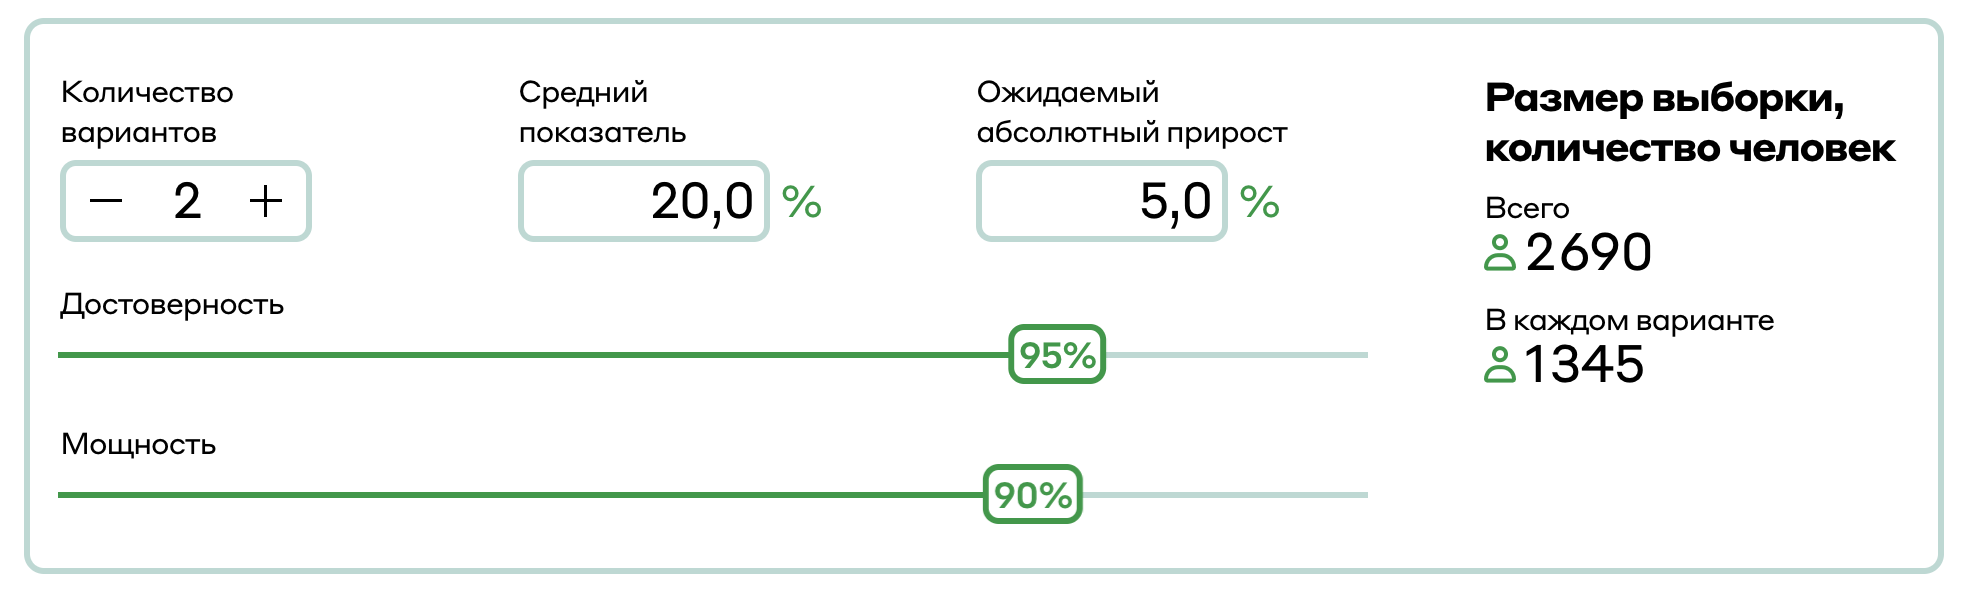

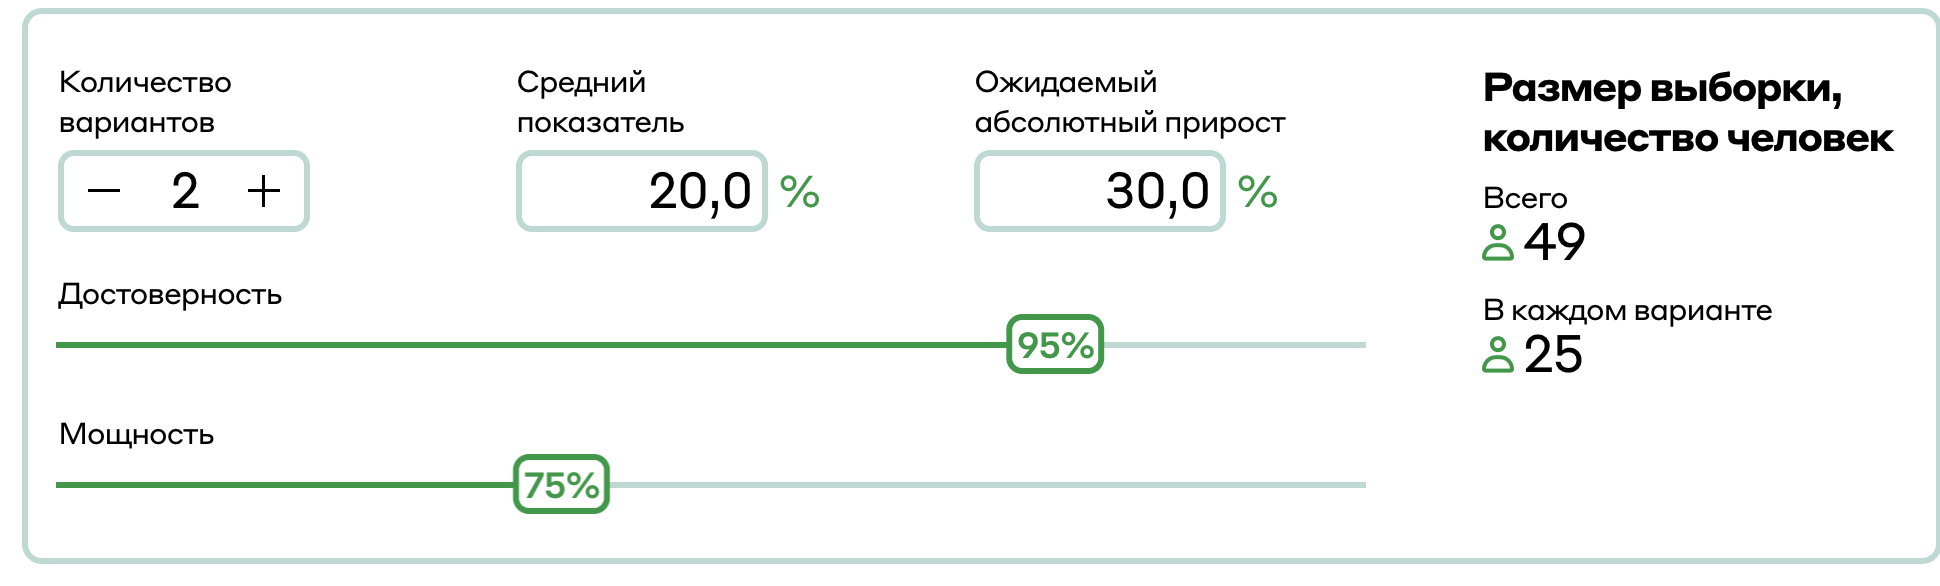

#  2. Linearization method


2. Реализовать метод линеаризации. Проверить для него корректность и мощность. Мощность должна быть больше, чем просто на обычных значениях конверсии пользователей.


In [42]:
import numpy as np
import scipy.stats as sps
import pandas as pd

class LinearizationTest:
    def __init__(self, p, effect):
        self.p = p
        self.effect = effect

    def simulate_linearization(self):
        n_exp = 1000
        p_values = []
        p_values_lin = []

        for _ in range(n_exp):
            records = []
            for _ in range(100):
                n_views = int(sps.expon.rvs(loc=100, scale=100))
                clicks = sps.bernoulli.rvs(p=self.p, size=n_views)
                records.append([n_views, np.sum(clicks), np.sum(clicks) / n_views, "A"])

            for _ in range(100):
                n_views = int(sps.expon.rvs(loc=100, scale=100))
                clicks = sps.bernoulli.rvs(p=self.p + self.effect, size=n_views)
                records.append([n_views, np.sum(clicks), np.sum(clicks) / n_views, "B"])

            df_data = pd.DataFrame(records, columns=["views", "clicks", "cr", "group"])
            cr_A = df_data[df_data["group"] == "A"]["clicks"].sum() / df_data[df_data["group"] == "A"]["views"].sum()
            df_data["cr_lin"] = df_data["clicks"] - cr_A * df_data["views"]

            x_a = df_data[df_data["group"] == "A"]["cr"]
            x_b = df_data[df_data["group"] == "B"]["cr"]
            p_value = sps.ttest_ind(x_a, x_b).pvalue
            p_values.append(p_value)

            x_a_lin = df_data[df_data["group"] == "A"]["cr_lin"]
            x_b_lin = df_data[df_data["group"] == "B"]["cr_lin"]
            p_value_lin = sps.ttest_ind(x_a_lin, x_b_lin).pvalue
            p_values_lin.append(p_value_lin)

        return p_values, p_values_lin


linearization_test = LinearizationTest(p=0.05, effect=0)
p_values, p_values_lin = linearization_test.simulate_linearization()


In [49]:
qq_plot = QQPlot(p_values)
qq_plot.generate_plot(title='no linear')

In [50]:
qq_plot = QQPlot(p_values_lin)
qq_plot.generate_plot(title='with linear')

In [51]:
linearization_test = LinearizationTest(p=0.05, effect=0.005)
p_values, p_values_lin = linearization_test.simulate_linearization()

p_val = np.array(p_values)
print(f'power without linear: {p_val[p_val < alpha].shape[0] / p_val.shape[0] * 100}')

p_val_lin = np.array(p_values_lin)
print(f'power with linear: {p_val_lin[p_val_lin < alpha].shape[0] / p_val_lin.shape[0] * 100}')

power without linear: 51.800000000000004
power with linear: 60.099999999999994


# 3. CUPED method

3.Реализовать метод CUPED. Проверить для него корректность и мощность. Данные на этапе до A/B тесте необходимо сгенерировать один раз, далее синтетически генерировать только часть, связанную с проведением A/B-теста.



In [57]:
import numpy as np
import scipy.stats as sps
import pandas as pd

class CupedTest:
    def __init__(self, distribution, pre_experiment, params_1, params_2):
        self.distribution = distribution
        self.pre_experiment = pre_experiment
        self.params_1 = params_1
        self.params_2 = params_2

    def perform_cuped_test(self):
        num_experiments = 1000
        p_values = []
        p_values_cuped = []

        for _ in range(num_experiments):
            df_group_A = pd.DataFrame()
            df_group_A["user"] = [f"A_{x:5}" for x in range(len(self.pre_experiment))]
            df_group_A["pre_exp"] = self.pre_experiment

            df_group_B = pd.DataFrame()
            df_group_B["pre_exp"] = self.pre_experiment
            df_group_B["user"] = [f"B_{x:5}" for x in range(len(self.pre_experiment))]

            df_group_A["payments"] = self.distribution(**self.params_1) * df_group_A["pre_exp"]
            df_group_B["payments"] = self.distribution(**self.params_2) * df_group_B["pre_exp"]

            p_values.append(sps.ttest_ind(df_group_A["payments"], df_group_B["payments"]).pvalue)

            x_a = df_group_A["pre_exp"]
            x_b = df_group_B["pre_exp"]
            y_a = df_group_A["payments"]
            y_b = df_group_B["payments"]
            theta = np.cov(x_a, y_a)[0, 1] / np.std(x_a)**2

            df_group_A["payments_cuped"] = df_group_A["payments"] - theta * df_group_A["pre_exp"]
            df_group_B["payments_cuped"] = df_group_B["payments"] - theta * df_group_B["pre_exp"]

            p_values_cuped.append(sps.ttest_ind(df_group_A["payments_cuped"], df_group_B["payments_cuped"]).pvalue)

        return p_values, p_values_cuped


In [60]:
dist = sps.expon.rvs
pre_exp = sps.norm.rvs(loc=100, scale=20, size=size)
param1 = dict(loc=100, scale=100, size=size)
param2 = dict(loc=100, scale=100, size=size)

cuped_test = CupedTest(distribution=dist, pre_experiment=pre_exp, params_1=param1, params_2=param2)
p_values, p_values_cuped = cuped_test.perform_cuped_test()

In [61]:
qq_plot = QQPlot(p_values_cuped)
qq_plot.generate_plot(title='Cuped')

In [64]:
dist = sps.expon.rvs
pre_exp = sps.norm.rvs(loc=100, scale=20, size=size)
effect = 0.005
param1 =  dict(loc=1, scale=0.1, size=size)
param2 = dict(loc=1 + effect, scale=0.1, size=size)

cuped_test = CupedTest(distribution=dist, pre_experiment=pre_exp, params_1=param1, params_2=param2)
p_values, p_values_cuped = cuped_test.perform_cuped_test()

In [65]:
p_values = np.array(p_values)
print(f'power ordinal test: {p_values[p_values < alpha].shape[0] / p_values.shape[0] * 100}')

power ordinal test: 12.5


In [66]:
p_values_cuped = np.array(p_values_cuped)
print(f'power with CUPED: {p_values_cuped[p_values_cuped < alpha].shape[0] / p_values_cuped.shape[0] * 100}')

power with CUPED: 93.89999999999999
